In [1]:
# add path to explore_by_example src folder
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


# import usual libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score

# our system imports
from aideme.io import *
from aideme.active_learning import *
from aideme.initial_sampling import StratifiedSampler
from aideme.explore import *
from aideme.utils.metrics import three_set_metric, classification_metrics
from aideme.utils.plotting import plot_polytope

%matplotlib inline

In [2]:
def plot_fscore(metrics):
    df_list = [pd.DataFrame.from_dict({i: metric for i, metric in enumerate(ls)}, orient='index') for ls in metrics]
    avg = sum([df['fscore'][~df['fscore'].isna()] for df in df_list]) / len(df_list)
    avg.plot(ylim=[0,1], marker='o')
    plt.show()

In [3]:
# DUMMY DATA
dim = 3
limit = 2 * (0.001)**(1. / dim)
X = np.random.uniform(low=-2, high=2, size=(100000, dim))  # do not forget to standardize the data. For this distribution, it should be fine without it.
X[:, -1] = np.random.randint(0, 3, 100000)
y_subspace = np.vstack([np.abs(X[:, i]) < limit for i in range(dim - 1)] + [X[:, -1] == 1]).T.astype('float')  # partial labels (for each subspace)
y = y_subspace.min(axis=1)

# visualize data distribution
print('selectivity :', 100 * y.sum() / len(y), '%')

#plt.figure(figsize=(10,8))
#plt.scatter(X[:, 0], X[:, 1], s=0.5, c=['b' if lb else 'r' for lb in y])
#plt.show()

selectivity : 0.338 %


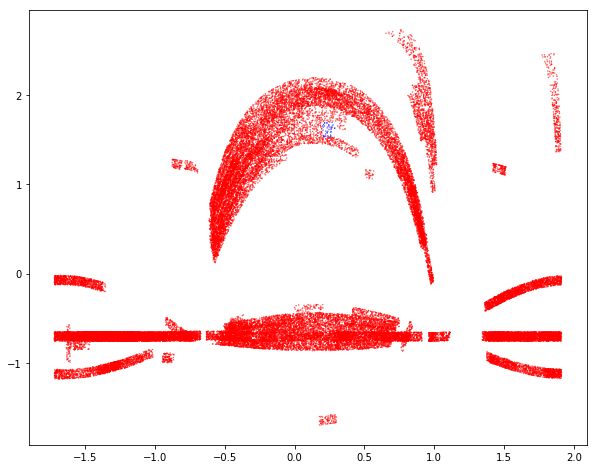

In [13]:
#X, y = read_task('sdss_q3_0.1%', distinct=False, get_raw=False)

X_sample = X.sample(50000)
y_sample = y.loc[X_sample.index]

plt.figure(figsize=(10, 8))
plt.scatter(X_sample.iloc[:, 0], X_sample.iloc[:, 1], c=['b' if lb else 'r' for lb in y_sample], s=0.1)
plt.show()

# NO FACTORIZATION EXAMPLE

iter: 0, fscore: 0.006750523332283581
iter: 10, fscore: 0.4225431094910977
iter: 20, fscore: 0.279508970727101
iter: 30, fscore: 0.8062387522495501
iter: 40, fscore: 0.8203026481715007
iter: 50, fscore: 0.8493570116350275
iter: 60, fscore: 0.8634043830681477
iter: 70, fscore: 0.8677217079725291
iter: 80, fscore: 0.8707482993197279
iter: 90, fscore: 0.872113676731794
iter: 99, fscore: 0.8731144631765749


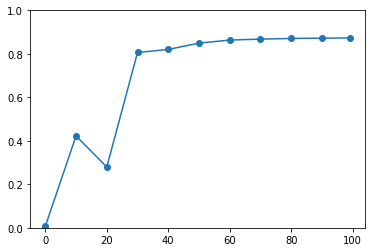

In [19]:
# SET-UP EXPLORATION CONFIGURATION
NUMBER_OF_ITERATIONS = 100  # number of points to be labeled by the user
SUBSAMPLING = 10000 #10000, 50000, float('inf')
INITIAL_SAMPLER = StratifiedSampler(pos=1, neg=1)  # start with one random positive sample and one random negative sample
CALLBACK = [ # callback functions to be called at the end of each iteration
    classification_metrics('fscore'), 
    #three_set_metric,
]
CALLBACK_SKIP = 10
PRINT_CALLBACK_RESULT = True

explore = PoolBasedExploration(NUMBER_OF_ITERATIONS, INITIAL_SAMPLER, SUBSAMPLING, CALLBACK, CALLBACK_SKIP, PRINT_CALLBACK_RESULT)

# CHOOSE AN ALGORITHM
#learner = RandomSampler(SVC(C=1e5, kernel='rbf', gamma='auto'))  # choose a random point
#learner = SimpleMargin(C=1024, kernel='rbf')  # choose point closest to SVM decision boundary
learner = KernelQueryByCommittee(kernel='rbf', sampling='deterministic', n_samples=8, warmup=100, thin=10, rounding=True)  # version space algorithm
#learner = DualSpaceModel(learner, sample_unknown_proba=0.5, mode='positive')  # Dual Space model


# RUN EXPLORATION
metrics = explore.run(X, y, learner, repeat=1)  # 'repeat' specifies how many times to repeat the exploration process

# COMPUTE AVERAGE F-SCORE OVER ALL REPEATS AND PLOT
plot_fscore(metrics)

# FACTORIZATION EXAMPLE

In [9]:
# SET-UP EXPLORATION CONFIGURATION
NUMBER_OF_ITERATIONS = 20
SUBSAMPLING = float('inf')
INITIAL_SAMPLER = StratifiedSampler(pos=1, neg=1)
CALLBACK = [
    classification_metrics('fscore'), 
    #three_set_metric, 
    # plot_polytope(), # plot the positive / negative / unknown regions
]
CALLBACK_SKIP = 2
PRINT_CALLBACK_RESULT = False

explore = PoolBasedExploration(NUMBER_OF_ITERATIONS, INITIAL_SAMPLER, SUBSAMPLING, CALLBACK, CALLBACK_SKIP, PRINT_CALLBACK_RESULT)

# Factorized AL algorithms
PARTITION = [[i] for i in range(dim)]  #[[0], [1]]

# FACTORIZED VERSION SPACE
# label_function = 'AND', 'OR', 'PROD'
# loss = 'GREEDY', 'SQUARED', 'PRODUCT'
# categorical = list of partition indexes to consider as purely categorical
learner = SubspatialVersionSpace(categorical=[2], warmup=100, thin=10, n_samples=8, rounding=True, kernel='rbf', gamma=None, partition=PARTITION, label_function='AND', loss='GREEDY')

# FACTORIZED SIMPLE MARGIN
#learner = SubspatialSimpleMargin(C=1024, kernel='rbf', gamma=5, partition=PARTITION, label_function='AND')

# FACTORIZED DSM
#learner = DualSpaceModel(SimpleMargin(C=1024, kernel='rbf'), mode='persist', sample_unknown_proba=0.5, partition=PARTITION)  # Dual Space model


# RUN EXPLORATION
metrics = explore.run(X, y_subspace, learner, repeat=10)  # use y_subspace here

# COMPUTE AVERAGE F-SCORE OVER ALL REPEATS AND PLOT
plot_fscore(metrics)

ValueError: Invalid indexes found in 'categorical' parameter.

In [7]:
from aideme.io import *
task = read_task('user_study_06')
X, y, partition, y_subspace, categorical = task['data'], task['labels'], task['partition'], task['partial_labels'], task['categorical']
print(y.sum())
X.head()

19.0


,height,drivetrain_year,transmission_10_speed_shiftable_automatic,transmission_2_speed,transmission_4_speed_automatic,transmission_4_speed_shiftable_automatic,transmission_5_speed_automatic,transmission_5_speed_manual,transmission_5_speed_shiftable_automatic,transmission_6_speed_automated_manual,...,class_off_road_vehicle,class_roadster_car,class_sport_car,class_sport_cars,class_sport_compact_car,class_subcompact_car,class_subcompact_crossover_suv,class_subcompact_mpv,class_subcompact_suv,class_supercar
id,,,,,,,,,,,,,,,,,,,,,
200713717,1.41224,6.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200727572,1.41224,6.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200727571,1.41224,6.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200727568,1.41224,6.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
200727569,1.41224,6.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for i in range(1, 19):
    s = str(i)
    if len(s)